In [ ]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요 라이브러리 Import 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 

In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']   # 평가 정보 데이터 컬럼명 설정 

dog_ratings = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_data_kfold.csv')
dog_ratings = dog_ratings[['m_no', 'goodsno', 'point']].astype(int)

In [ ]:
len(np.unique(dog_ratings['m_no']))

1633

In [ ]:
dog_item = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_item.csv')
dog_item.set_index('goodsno', inplace=True)

In [ ]:
rating_matrix = dog_ratings.pivot(index='m_no', columns='goodsno', values='point')

In [ ]:
item_id_index = []   # 아이디를 인덱스로 매핑해주는 맵 
index_item_id = []   # 인덱스를 아이디로 매핑해주는 맵 
for i, one_id in enumerate(rating_matrix):   # 각 아이템에 대해 
  item_id_index.append([one_id, i])   # 현재 아이템의 아이디와 인덱스 저장  
  index_item_id.append([i, one_id])   # 현재 아이템의 인덱스와 아이디 저장 

item_id_index = dict(item_id_index)
index_item_id = dict(index_item_id)
user_id_index = []
index_user_id = [] 

for i, one_id in enumerate(rating_matrix.T):   # 같은 작업을 사용자 아이디에 대해 실행 
  user_id_index.append([one_id, i])
  index_user_id.append([i, one_id])

user_id_index = dict(user_id_index)
index_user_id = dict(index_user_id)

In [ ]:
len(user_id_index)

1633

In [ ]:
def convert_mno(data):
  return user_id_index[data]

def convert_gno(data):
  return item_id_index[data]

data_df = dog_ratings.copy()

data_df['m_no'] = data_df['m_no'].apply(convert_mno)
data_df['goodsno'] = data_df['goodsno'].apply(convert_gno)
data_df

,m_no,goodsno,point
0,33,30,5
1,33,27,5
2,33,29,5
3,33,2557,3
4,33,227,5
...,...,...,...
99995,1469,952,5
99996,1469,757,5
99997,1469,680,5
99998,1469,2296,5


In [ ]:
np.unique(dog_ratings.point.values)

array([1, 2, 3, 4, 5])

In [ ]:
from sklearn.model_selection import StratifiedKFold 

def split_df(df, kfold_n=5):
    '''
    df col: img_path, label
    '''
    kfold = StratifiedKFold(n_splits=kfold_n, shuffle=True, random_state=42)
    
    # 클래스 비율 고려하여 Fold 별로 데이터 분리 
    X = np.array(df) 
    y = df.m_no.values 
    
    datas = [] 
    for i, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        train_df = df.iloc[train_idx].copy().reset_index(drop=True)
        test_df = df.iloc[val_idx].copy().reset_index(drop=True) 
        
        datas.append((train_df, test_df))
    return datas

datas = split_df(data_df)

In [ ]:
len(datas[0][0]['goodsno'].unique()), len(datas[0][1]['goodsno'].unique())

(5720, 3460)

In [ ]:
def RMSE(y_true, y_pred):
  '''
  RMSE 함수 정의 
  '''
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import SGD, Adamax 

In [ ]:
data_df.m_no.max() + 1

1633

In [ ]:
# variable 초기화
K = 200   # Latent factor (잠재요인) 수 

# M = len(dog_ratings['m_no'].unique()) + 1   # 사용자 아이디의 최대값을 구함 (embedding에 사용)
# N = len(dog_ratings['goodsno'].unique()) + 1   # 영화 아이디의 최대값을 구함 (embedding에 사용) 
M = data_df.m_no.max() + 1 
N = data_df.goodsno.max() + 1 

In [ ]:
# model0
user = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)   # 아이템 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)   # 아이템 bias embedding layer 

R = layers.dot([P_embedding, Q_embedding], axes=2)   # 사용자, 아이템 embedding 레이어를 내적 연산 (dot product). axes를 통해 축을 설정함
R = layers.add([R, user_bias, item_bias])   # 사용자 bias, 아이템 bias를 더함 
R = Flatten()(R)   # 차원 압축 (1차원 배열 형태로 변환)

model0 = Model(inputs=[user, item], outputs=R)   # 입력과 출력 정의 
model0.compile(loss=RMSE, optimizer=SGD(), metrics=[RMSE])   # 모델 컴파일 
model0.summary()   # 모델 구조 요약 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       326600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       1226400     ['input_2[0][0]']                
                                                                                              

In [ ]:
num_fold = 5 

results = [] 
for fold in range(0, num_fold):
  x = datas[fold][0] 
  y = datas[fold][0]['m_no']
  mu = datas[fold][0].point.mean()   # 전체 평균  
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
  
  result = model0.fit(
    x = [x_train.m_no.values, x_train.goodsno.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 100,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values],   
        x_val.point.values - mu
    )
  )
    
  results.append(result)

Epoch 1/100
125/125 [==============================] - 2s 5ms/step - loss: 13.5996 - RMSE: 0.9069 - val_loss: 13.2824 - val_RMSE: 0.9078
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 12.9798 - RMSE: 0.9063 - val_loss: 12.6783 - val_RMSE: 0.9073
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 12.3902 - RMSE: 0.9055 - val_loss: 12.1036 - val_RMSE: 0.9068
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 11.8298 - RMSE: 0.9054 - val_loss: 11.5569 - val_RMSE: 0.9063
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 11.2962 - RMSE: 0.9046 - val_loss: 11.0369 - val_RMSE: 0.9058
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 10.7891 - RMSE: 0.9043 - val_loss: 10.5423 - val_RMSE: 0.9054
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 10.3064 - RMSE: 0.9038 - val_loss: 10.0718 - val_RMSE: 0.9049
Epoch 8/100
125/125 [====================

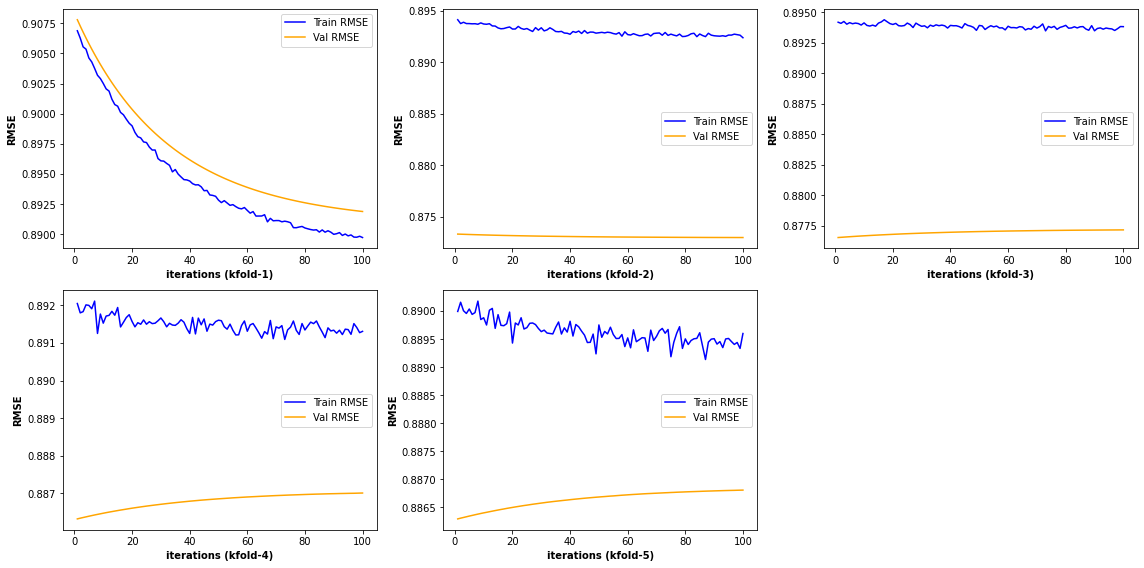

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], results[idx].history['RMSE'], color='blue', label = 'Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], results[idx].history['val_RMSE'], color='orange', label = 'Val RMSE')
      # ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      idx += 1
      ax[i, j].legend()
    except IndexError:
       ax[i, j].set_visible(False)

f.tight_layout()
plt.show()

In [ ]:
 # Keras Model
user = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)   # 아이템 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)   # 아이템 bias embedding layer 
                       
# Concatenate layers 
from tensorflow.keras.layers import Dense, Concatenate, Activation 

# Concatenate를 수행하기 위해, 각각의 레이어들을 1차원으로 변환함 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

# Neural network
R = Dense(2048)(R)   # 노드가 2,048개인 Dense Layer 추가 
R = Activation('relu')(R)   # 활성화 함수로 linear 사용 
R = Dense(256)(R)   # 노드가 256개인 Dense Layer 추가 
R = Activation('linear')(R)   # 활성화 함수로 linear 사용 
R = Dense(1)(R)   # 노드가 1개인 출력 Dense Layer 추가 

In [ ]:
# model 생성 
model1 = Model(inputs=[user, item], outputs=R)
model1.compile(   
    loss = RMSE,   # loss 함수로 앞서 정의한 RMSE 사용 
    optimizer = SGD(),   # optimizer: SGD
    metrics=[RMSE]   # 측정지표: RMSE
)

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       326600      ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       1226400     ['input_4[0][0]']                
                                                                                            

In [ ]:
num_fold = 5 

results1 = [] 
for fold in range(0, num_fold):
  x = datas[fold][0] 
  y = datas[fold][0]['m_no']
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
  
  mu = datas[fold][0].point.mean()   # 전체 평균  
  result1 = model1.fit(
    x = [x_train.m_no.values, x_train.goodsno.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 100,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values],   
        x_val.point.values - mu
    )
  )
    
  results1.append(result1)

Epoch 1/100
125/125 [==============================] - 1s 6ms/step - loss: 13.6022 - RMSE: 0.9059 - val_loss: 13.2853 - val_RMSE: 0.9071
Epoch 2/100
125/125 [==============================] - 0s 4ms/step - loss: 12.9825 - RMSE: 0.9055 - val_loss: 12.6813 - val_RMSE: 0.9070
Epoch 3/100
125/125 [==============================] - 0s 4ms/step - loss: 12.3929 - RMSE: 0.9049 - val_loss: 12.1064 - val_RMSE: 0.9064
Epoch 4/100
125/125 [==============================] - 0s 4ms/step - loss: 11.8323 - RMSE: 0.9046 - val_loss: 11.5597 - val_RMSE: 0.9060
Epoch 5/100
125/125 [==============================] - 0s 4ms/step - loss: 11.2987 - RMSE: 0.9040 - val_loss: 11.0397 - val_RMSE: 0.9057
Epoch 6/100
125/125 [==============================] - 0s 4ms/step - loss: 10.7914 - RMSE: 0.9037 - val_loss: 10.5451 - val_RMSE: 0.9053
Epoch 7/100
125/125 [==============================] - 0s 4ms/step - loss: 10.3091 - RMSE: 0.9036 - val_loss: 10.0744 - val_RMSE: 0.9049
Epoch 8/100
125/125 [====================

https://dbstndi6316.tistory.com/275  - kfold

In [ ]:
np.mean(results1[0].history['val_RMSE'])

0.8301696455478669

In [ ]:
val_rmse = 0 
for idx in range(5):
    val_rmse += np.mean(results1[idx].history['val_RMSE'])
    
val_rmse / 5

0.7888492954969406

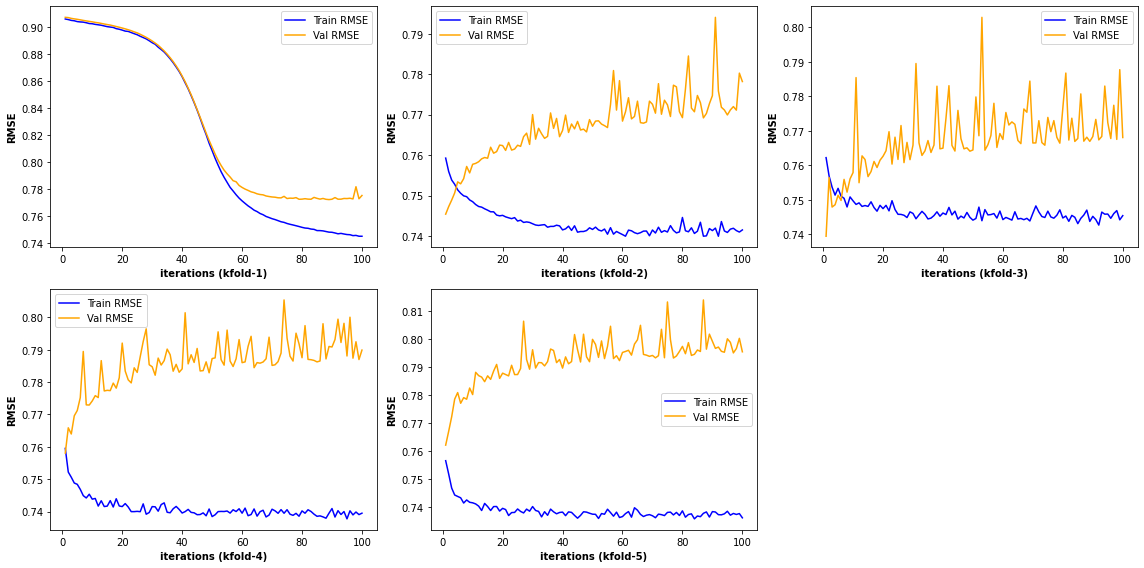

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], results1[idx].history['RMSE'], color='blue', label = 'Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], results1[idx].history['val_RMSE'], color='orange', label = 'Val RMSE')
      # ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      idx += 1
      ax[i, j].legend()
    except IndexError:
       ax[i, j].set_visible(False)

f.tight_layout()
plt.show()

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_user.csv')
users = users[['m_no', 'dogname']]  # 사용자 데이터를 읽어와서 ID와 성별(sex)만 남김 

p_type = {}
def convert_type(x):
  '''
  현재 string으로 되어 있는 성별을 int로 바꾸는 함수 
  '''
  if x in p_type:   # 현재의 sex에 대응하는 int값이 dictionary에 존재하면 
    return p_type[x]   # 해당 값 반환   
  else:   # 그렇지 않으면 
    p_type[x] = len(p_type)   # 새로운 element를 새로운 int값과 같이 dictionary에 추가 
    return p_type[x]   #새로운 int값 반환 

users['dogname'] = users['dogname'].apply(convert_type)   # 사용자 데이터의 'sex' 컬럼을 int로 변환 
L = len(p_type)   # 성별의 unique value의 개수를 저장함 (embedding 하는데 사용)

In [ ]:
len(users)

82020

In [ ]:
for idx, mno in enumerate(users['m_no']):
  try:
    users['m_no'][idx] = user_id_index[mno]
  except:
    users['m_no'][idx] = 9999

In [ ]:
users['m_no'].value_counts()

9999    80387
885         1
472         1
1015        1
181         1
        ...  
143         1
1347        1
1387        1
1216        1
1469        1
Name: m_no, Length: 1634, dtype: int64

In [ ]:
L

174

In [ ]:
users['m_no'].unique()

array([  33, 9999,  599, ..., 1245, 1523, 1469])

In [ ]:
users

,m_no,dogname
0,33,0
1,9999,0
2,599,0
3,338,1
4,71,2
...,...,...
82015,9999,10
82016,9999,22
82017,9999,1
82018,9999,0


In [ ]:
# Keras Model
user2 = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item2 = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정
p_type = Input(shape=(1, ))   # 성별 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user2)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item2)   # 아이템 embedding layer
type_embedding = Embedding(L, 3, embeddings_regularizer=l2())(p_type)  # 반려동물 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user2)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item2)   # 아이템 bias embedding layer 

from tensorflow.keras.layers import Dense, Concatenate, Activation 

# Concatenate를 수행하기 위해, 각각의 레이어들을 1차원으로 변환함 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
type_layer = Flatten()(type_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, type_layer])

# Neural network
R = Dense(2048)(R)   # 노드가 2,048개인 Dense Layer 추가 
R = Activation('relu')(R)   # 활성화 함수로 linear 사용 
R = Dense(256)(R)   # 노드가 256개인 Dense Layer 추가 
R = Activation('linear')(R)   # 활성화 함수로 linear 사용 
R = Dense(1)(R)   # 노드가 1개인 출력 Dense Layer 추가 

In [ ]:
# model 생성 
model2 = Model(inputs=[user2, item2, p_type], outputs=R)
model2.compile(   
    loss = RMSE,   # loss 함수로 앞서 정의한 RMSE 사용 
    optimizer = SGD(),   # optimizer: SGD
    metrics=[RMSE]   # 측정지표: RMSE
)

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 200)       326600      ['input_8[0][0]']                
                                                                                            

In [ ]:
x = datas[0][0]
y = datas[0][0]['m_no']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

train_type = pd.merge(x_train, users, on='m_no')['dogname']   # train set과 사용자 데이터 병합  
val_type = pd.merge(x_val, users, on='m_no')['dogname']   # test set과 사용자 데이터 병합 

In [ ]:
len(x_train.m_no.values), len(x_train.goodsno.values), len(train_type.values)

(64000, 64000, 64000)

In [ ]:
num_fold = 5   # kfold 수  

results2 = [] 
for fold in range(0, num_fold):
  x = datas[fold][0]
  y = datas[fold][0]['m_no']
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
  
  mu = datas[fold][0].point.mean()   # 전체 평균

  train_type = pd.merge(x_train, users, on='m_no')['dogname']   # train set과 사용자 데이터 병합  
  val_type = pd.merge(x_val, users, on='m_no')['dogname']   # test set과 사용자 데이터 병합 

  result2 = model2.fit(
    x = [x_train.m_no.values, x_train.goodsno.values, train_type.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 100,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values, val_type.values],   
        x_val.point.values - mu,
    )
  )
    
  results2.append(result2)

Epoch 1/100
125/125 [==============================] - 1s 7ms/step - loss: 13.6076 - RMSE: 0.9077 - val_loss: 13.2797 - val_RMSE: 0.8969
Epoch 2/100
125/125 [==============================] - 1s 4ms/step - loss: 12.9879 - RMSE: 0.9074 - val_loss: 12.6753 - val_RMSE: 0.8965
Epoch 3/100
125/125 [==============================] - 1s 4ms/step - loss: 12.3982 - RMSE: 0.9069 - val_loss: 12.1005 - val_RMSE: 0.8962
Epoch 4/100
125/125 [==============================] - 1s 4ms/step - loss: 11.8373 - RMSE: 0.9065 - val_loss: 11.5536 - val_RMSE: 0.8958
Epoch 5/100
125/125 [==============================] - 1s 4ms/step - loss: 11.3040 - RMSE: 0.9063 - val_loss: 11.0335 - val_RMSE: 0.8954
Epoch 6/100
125/125 [==============================] - 1s 4ms/step - loss: 10.7965 - RMSE: 0.9060 - val_loss: 10.5387 - val_RMSE: 0.8951
Epoch 7/100
125/125 [==============================] - 1s 4ms/step - loss: 10.3135 - RMSE: 0.9053 - val_loss: 10.0681 - val_RMSE: 0.8948
Epoch 8/100
125/125 [====================

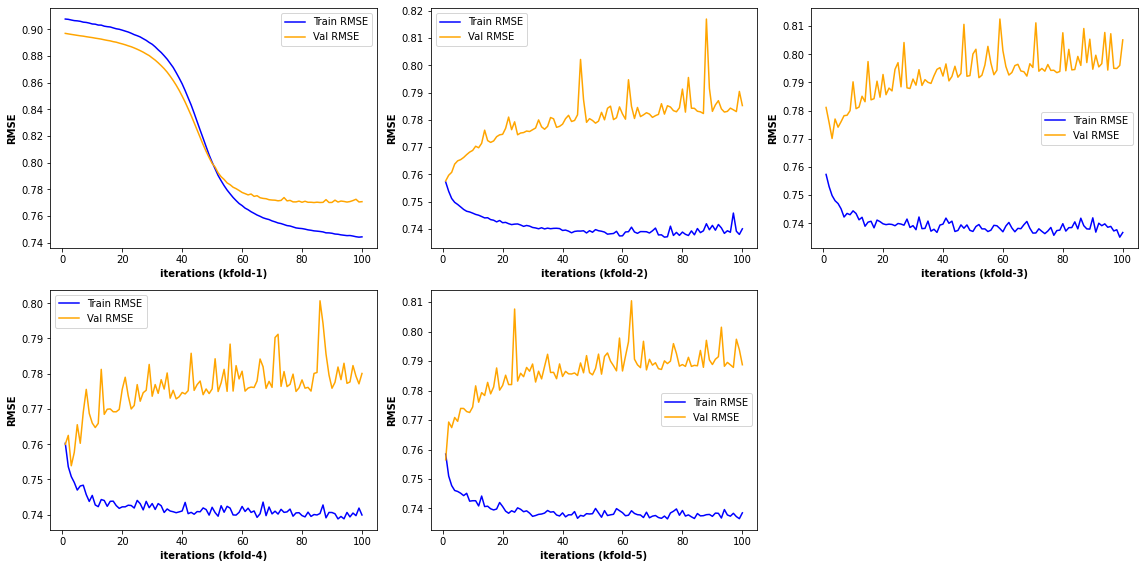

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], results2[idx].history['RMSE'], color='blue', label = 'Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], results2[idx].history['val_RMSE'], color='orange', label = 'Val RMSE')
      # ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      idx += 1
      ax[i, j].legend()
    except IndexError:
       ax[i, j].set_visible(False)

f.tight_layout()
plt.show()

In [ ]:
def convert_sent(point_list):
  list_p = []
  for idx, point in enumerate(point_list):
    if point > 3:
      list_p.append(0)
    else:
      list_p.append(1)
  print(len(list_p))
  return list_p

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix(model): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model.predict([np.array([user, ]),np.array([item, ])]) + mu for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
  return cmdf

In [ ]:
mu

4.4033875

In [ ]:
c_matrix(model0)

20000
20000


,예측값(0),예측값(1)
실제값(0),16951,0
실제값(1),3049,0


In [ ]:
c_matrix(model1)

20000
20000


,예측값(0),예측값(1)
실제값(0),16884,67
실제값(1),2781,268


In [ ]:
def recom_items(user_id, n_items):   # 4분 
  user_item = rating_matrix.loc[user_id].copy()
  for item in rating_matrix:
    if pd.notnull(user_item.loc[item]):
      user_item.loc[item] = 0
    else:   # model.predict([np.array([user_id, ]),np.array([item, ])]) + mu
      # 푸들 = 0 
      # user_item.loc[item] = model2.predict([np.array([user_id, ]),np.array([item, ]), np.array([0, ])]) + mu
      user_item.loc[item] = model1.predict([np.array([user_id, ]),np.array([item, ])]) + mu

  item_sort = user_item.sort_values(ascending=False)[:n_items]
  recom_items = dog_item.loc[item_sort.index]
  recommendations = recom_items['goodsnm']
  return recommendations 

recom_items(98380, 5)

goodsno
492                 브리더 크롬 철장 중
1436       미라클 순 트리트먼트 샴푸 750ml
3527          굿프랜드 슬라이스 사사미 30g
4000    오~사사미 웰빙 고구마 치킨 저키 400g
3814       미스터두크 하네스&리드줄 블루그린 중
Name: goodsnm, dtype: object

In [ ]:
# datas[4][1]

test_type = pd.merge(datas[4][1], users, on='m_no')['dogname']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix_2(model2): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[2][1]['m_no'], datas[2][1]['goodsno'], test_type.values)    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model2.predict([np.array([user, ]),np.array([item, ]), np.array([dogtype, ])]) + mu for (user, item, dogtype) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[2][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(0)', '실제값(1)'], columns=['예측값(0)', '예측값(1)'])
  return cmdf

In [ ]:
c_matrix_2(model2)

20000
20000


,예측값(0),예측값(1)
실제값(0),16907,44
실제값(1),2864,185


In [ ]:
# Keras Model
user3 = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item3 = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정
p_type = Input(shape=(1, ))   # 성별 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user3)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item3)   # 아이템 embedding layer
type_embedding = Embedding(L, 3, embeddings_regularizer=l2())(p_type)  # 반려동물 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user3)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item3)   # 아이템 bias embedding layer 

from tensorflow.keras.layers import Dense, Concatenate, Activation 

# Concatenate를 수행하기 위해, 각각의 레이어들을 1차원으로 변환함 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
type_layer = Flatten()(type_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, type_layer])

# Neural network
R = Dense(2048)(R)   # 노드가 2,048개인 Dense Layer 추가 
R = Activation('relu')(R)   # 활성화 함수로 linear 사용 
R = Dense(256)(R)   # 노드가 256개인 Dense Layer 추가 
R = Activation('linear')(R)   # 활성화 함수로 linear 사용 
R = Dense(1)(R)   # 노드가 1개인 출력 Dense Layer 추가 

In [ ]:
# model 생성 
model3 = Model(inputs=[user3, item3, p_type], outputs=R)
model3.compile(   
    loss = RMSE,   # loss 함수로 앞서 정의한 RMSE 사용 
    optimizer = SGD(),   # optimizer: SGD
    metrics=[RMSE]   # 측정지표: RMSE
)

# model2.summary()

In [ ]:
num_fold = 5   # kfold 수  

results3 = [] 
for fold in range(0, num_fold):
  x = datas[fold][0]
  y = datas[fold][0]['m_no']
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
  
  train_type = pd.merge(x_train, users, on='m_no')['dogname']   # train set과 사용자 데이터 병합  
  val_type = pd.merge(x_val, users, on='m_no')['dogname']   # test set과 사용자 데이터 병합 

  result2 = model3.fit(
    x = [x_train.m_no.values, x_train.goodsno.values, train_type.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 500,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values, val_type.values],   
        x_val.point.values - mu
    )
  )
    
  results3.append(result2)